In [14]:
import h5py
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import regularizers


# Load HDF5 spectrogram data
def load_hdf5_spectrograms(file_path):
    X = []
    y = []
    with h5py.File(file_path, 'r') as f:
        species_list = list(f.keys())
        print("Species in dataset:", species_list)
        for species in species_list:
            data = f[species][:]
            # shape (freq_bins=128, time_bins=517, samples)
            for i in range(data.shape[2]):
                X.append(data[:, :, i])
                y.append(species)
    X = np.array(X)  # shape (samples, 128, 517)
    y = np.array(y)
    return X, y

# Normalize spectrograms to [0, 1]
def normalize_spectrograms(X):
    # Normalize per sample by min-max scaling
    X_min = X.min(axis=(1,2), keepdims=True)
    X_max = X.max(axis=(1,2), keepdims=True)
    X_norm = (X - X_min) / (X_max - X_min + 1e-6)
    return X_norm

# Prepare dataset 
def prepare_dataset(file_path):
    X, y = load_hdf5_spectrograms(file_path)
    X = normalize_spectrograms(X)
    X = X[..., np.newaxis]  # Add channel dimension

    # Encode labels to integers
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    class_names = le.classes_

    #  Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Convert to one-hot encoding
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=len(class_names))
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=len(class_names))

    print(f"Classes: {class_names}")
    print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
    return X_train, X_test, y_train_cat, y_test_cat, class_names


file_path = '/kaggle/input/nndata/bird_spectrograms.hdf5'

X_train, X_test, y_train_cat, y_test_cat, class_names = prepare_dataset(file_path)


Species in dataset: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Classes: ['amecro' 'amerob' 'bewwre' 'bkcchi' 'daejun' 'houfin' 'houspa' 'norfli'
 'rewbla' 'sonspa' 'spotow' 'whcspa']
Train samples: 1584, Test samples: 397


Model 1 : Base Model

In [4]:


def build_basic_cnn(input_shape=(128, 517, 1), num_classes=12):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


model = build_basic_cnn()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747892189.525067      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747892189.525849      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 517, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 258, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 258, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 129, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,871,564 (64.36 MB)

 Trainable params: 16,871,564 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model.fit(X_train, y_train_cat, 
                    epochs=20, 
                    batch_size=32,
                    validation_data=(X_test, y_test_cat))


Epoch 1/20


I0000 00:00:1747892197.821018     103 service.cc:148] XLA service 0x7adbb40094d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747892197.821765     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747892197.821792     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747892198.136636     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/50 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.1285 - loss: 3.1705

I0000 00:00:1747892205.268631     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 216ms/step - accuracy: 0.2471 - loss: 2.5249 - val_accuracy: 0.3174 - val_loss: 2.1830
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3086 - loss: 2.1865 - val_accuracy: 0.3199 - val_loss: 2.0879
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3468 - loss: 2.0373 - val_accuracy: 0.3426 - val_loss: 2.0124
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3503 - loss: 1.9787 - val_accuracy: 0.4156 - val_loss: 1.8929
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.4131 - loss: 1.7968 - val_accuracy: 0.4383 - val_loss: 1.7879
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5160 - loss: 1.5340 - val_accuracy: 0.4307 - val_loss: 1.8294
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5865 - loss: 1.2649 - val_accuracy: 0.4559 - val_loss: 1.8205
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6529 - loss: 1.0186 - val_accuracy: 0.4559 - val_loss: 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Test Accuracy: 0.4836

Classification Report:
              precision    recall  f1-score   support

      amecro       0.67      0.46      0.55        13
      amerob       0.47      0.51      0.49        35
      bewwre       0.43      0.21      0.28        29
      bkcchi       0.00      0.00      0.00         9
      daejun       0.32      0.32      0.32        25
      houfin       0.40      0.24      0.30        17
      houspa       0.61      0.84      0.70       126
      norfli       0.00      0.00      0.00         7
      rewbla       0.44      0.29      0.35        38
      sonspa       0.35      0.51      0.42        53
      spotow       0.22      0.07      0.11        27
      whcspa       0.31      0.22      0.26        18

    accuracy                           0.48       397
   macro avg       0.35      0.31      0.31       397
weighted avg       0.44      0.48      0.45       397



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


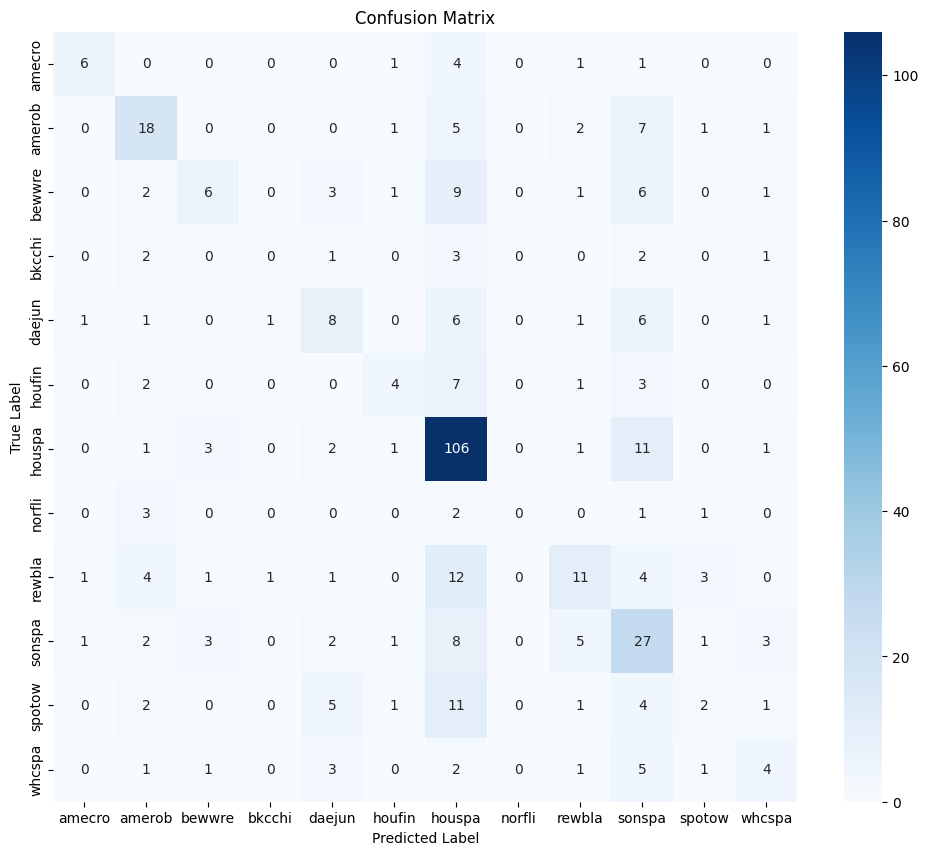

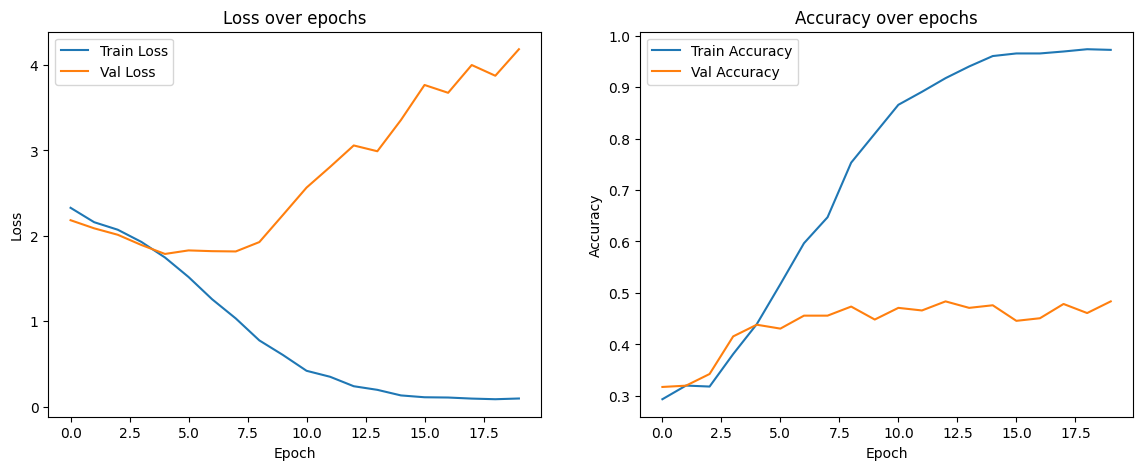

In [6]:

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Accuracy
test_acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot training history - Loss and Accuracy

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Model 2 : Adding Class Weights 

In [7]:
from sklearn.utils.class_weight import compute_class_weight

y_train_classes = np.argmax(y_train_cat, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
class_weights_dict = dict(enumerate(class_weights))

def build_basic_cnn(input_shape=(128, 517, 1), num_classes=12):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model
    
model_cw = build_basic_cnn()
model_cw.summary()



history_cw = model_cw.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 517, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 258, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 258, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 129, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,871,564 (64.36 MB)

 Trainable params: 16,871,564 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.1109 - loss: 2.7296 - val_accuracy: 0.2040 - val_loss: 2.4744
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.2054 - loss: 2.5816 - val_accuracy: 0.2443 - val_loss: 2.3518
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.2295 - loss: 2.4675 - val_accuracy: 0.2217 - val_loss: 2.2703
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.2313 - loss: 2.4267 - val_accuracy: 0.2720 - val_loss: 2.2018
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.3070 - loss: 2.1276 - val_accuracy: 0.2821 - val_loss: 2.1659
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.3868 - loss: 1.6864 - val_accuracy: 0.3149 - val_loss: 2.1381
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.4689 - loss: 1.4655 - val_accuracy: 0.3275 - val_loss: 2.2357
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5695 - loss: 1.0637 - val_accuracy: 0.3325 -

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
 Class Weights Test Accuracy: 0.4509

Classification Report:
              precision    recall  f1-score   support

      amecro       0.60      0.46      0.52        13
      amerob       0.50      0.46      0.48        35
      bewwre       0.36      0.14      0.20        29
      bkcchi       0.10      0.11      0.11         9
      daejun       0.35      0.28      0.31        25
      houfin       0.25      0.12      0.16        17
      houspa       0.58      0.77      0.66       126
      norfli       0.20      0.14      0.17         7
      rewbla       0.26      0.13      0.18        38
      sonspa       0.42      0.58      0.49        53
      spotow       0.20      0.22      0.21        27
      whcspa       0.27      0.17      0.21        18

    accuracy                           0.45       397
   macro avg       0.34      0.30      0.31       397
weighted avg       0.42      0.45      0.42       397



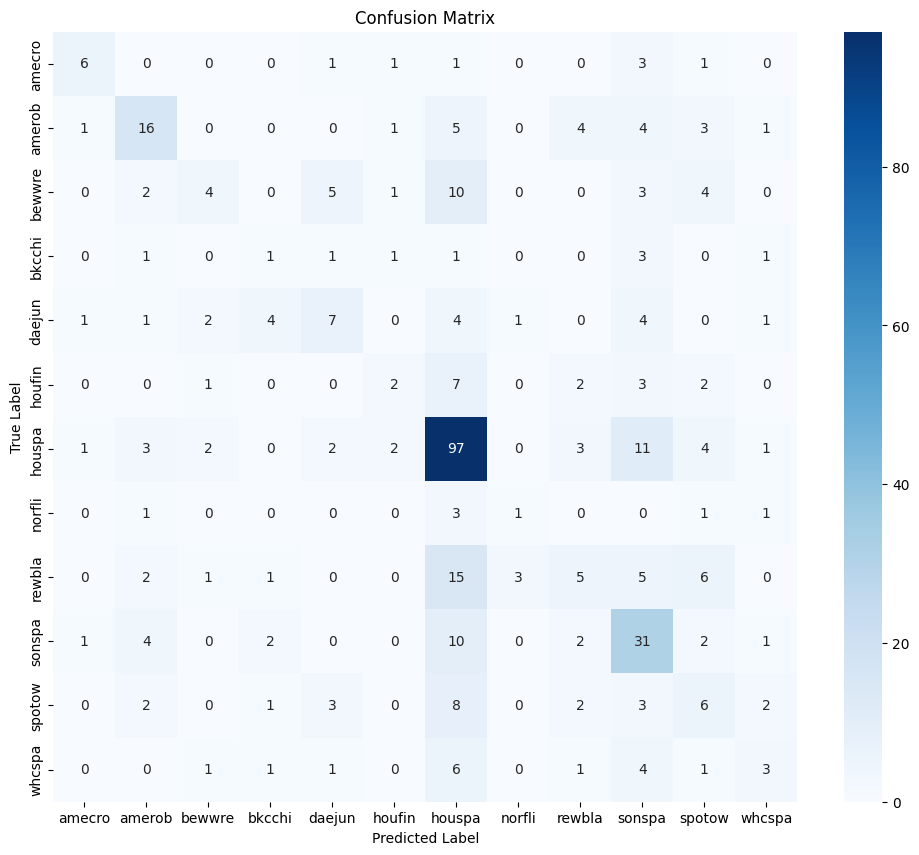

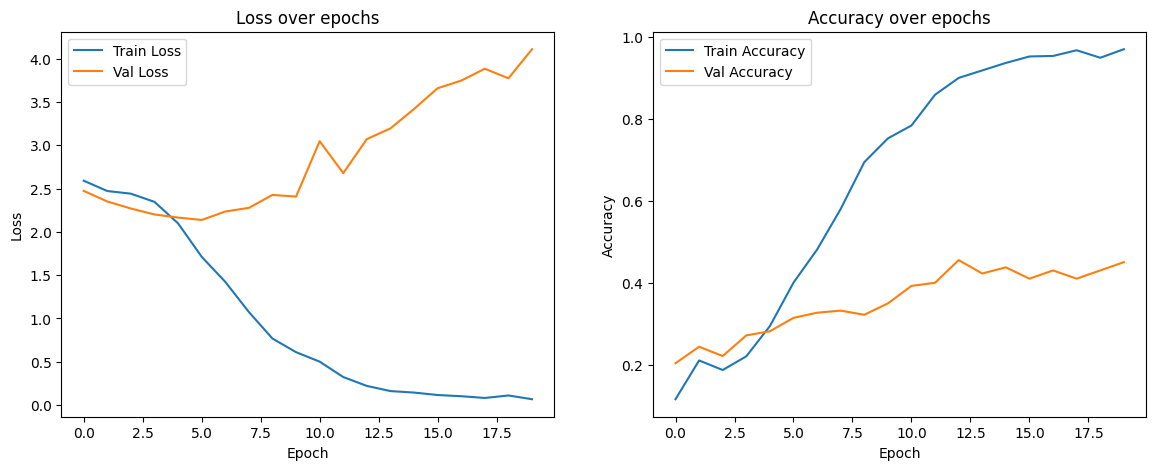

In [8]:


y_pred_prob = model_cw.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Accuracy
test_acc_cw = accuracy_score(y_true, y_pred)
print(f" Class Weights Test Accuracy: {test_acc_cw:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot training history - Loss and Accuracy

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_cw.history['loss'], label='Train Loss')
plt.plot(history_cw.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cw.history['accuracy'], label='Train Accuracy')
plt.plot(history_cw.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Model 3 : Balancing the Samples 

In [9]:

# Build Downsample Model:
def downsample_data(X, y, target_count):
    classes = np.argmax(y, axis=1)
    indices_list = []
    for cls in np.unique(classes):
        cls_indices = np.where(classes == cls)[0]
        if len(cls_indices) > target_count:
            cls_indices = np.random.choice(cls_indices, target_count, replace=False)
        indices_list.extend(cls_indices)
    indices_list = np.array(indices_list)
    return X[indices_list], y[indices_list]

min_class_count = min([30])  
X_train_bal, y_train_bal = downsample_data(X_train, y_train_cat, min_class_count)

print(f"Balanced training data shape: {X_train_bal.shape}")
print(f"Balanced labels distribution: {np.bincount(np.argmax(y_train_bal, axis=1))}")

def build_basic_cnn(input_shape=(128, 517, 1), num_classes=12):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model
    
model_downsam = build_basic_cnn()
model_downsam.summary()

# Then train on balanced data:
history_downsam = model_downsam.fit(
    X_train_bal, y_train_bal,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test_cat)
)


Balanced training data shape: (360, 128, 517, 1)
Balanced labels distribution: [30 30 30 30 30 30 30 30 30 30 30 30]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 128, 517, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 258, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 258, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 129, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,871,564 (64.36 MB)

 Trainable params: 16,871,564 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 524ms/step - accuracy: 0.0683 - loss: 3.4299 - val_accuracy: 0.0428 - val_loss: 2.5018
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.0946 - loss: 2.4809 - val_accuracy: 0.0605 - val_loss: 2.5035
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.0898 - loss: 2.4857 - val_accuracy: 0.0806 - val_loss: 2.4836
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.1183 - loss: 2.4694 - val_accuracy: 0.0982 - val_loss: 2.4953
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.1055 - loss: 2.4397 - val_accuracy: 0.0932 - val_loss: 2.4955
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.1116 - loss: 2.4267 - val_accuracy: 0.1285 - val_loss: 2.5087
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.1752 - loss: 2.3537 - val_accuracy: 0.1134 - val_loss: 2.5073
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.2138 - loss: 2.3075 - val_accuracy: 0.2443 -

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
 Downsampled Test Accuracy: 0.2317

Classification Report:
              precision    recall  f1-score   support

      amecro       0.22      0.31      0.26        13
      amerob       0.32      0.49      0.39        35
      bewwre       0.09      0.07      0.08        29
      bkcchi       0.13      0.56      0.21         9
      daejun       0.24      0.16      0.19        25
      houfin       0.09      0.29      0.14        17
      houspa       0.60      0.17      0.26       126
      norfli       0.20      0.43      0.27         7
      rewbla       0.15      0.08      0.10        38
      sonspa       0.26      0.26      0.26        53
      spotow       0.24      0.26      0.25        27
      whcspa       0.18      0.39      0.25        18

    accuracy                           0.23       397
   macro avg       0.23      0.29      0.22       397
weighted avg       0.33      0.23      0.23       397



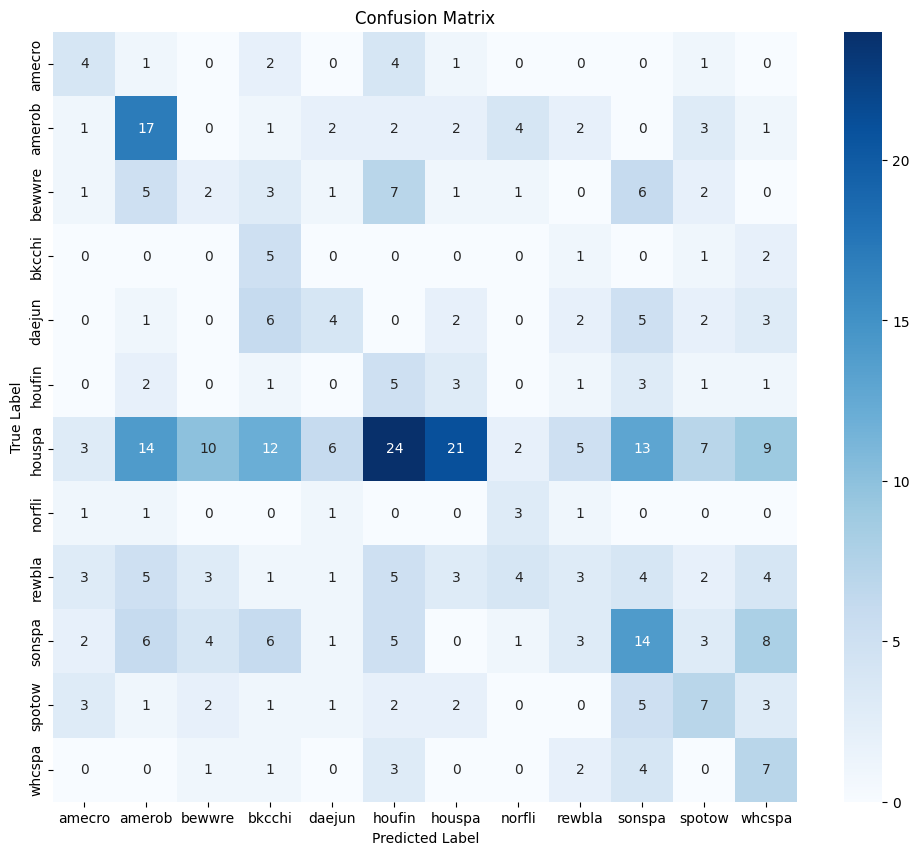

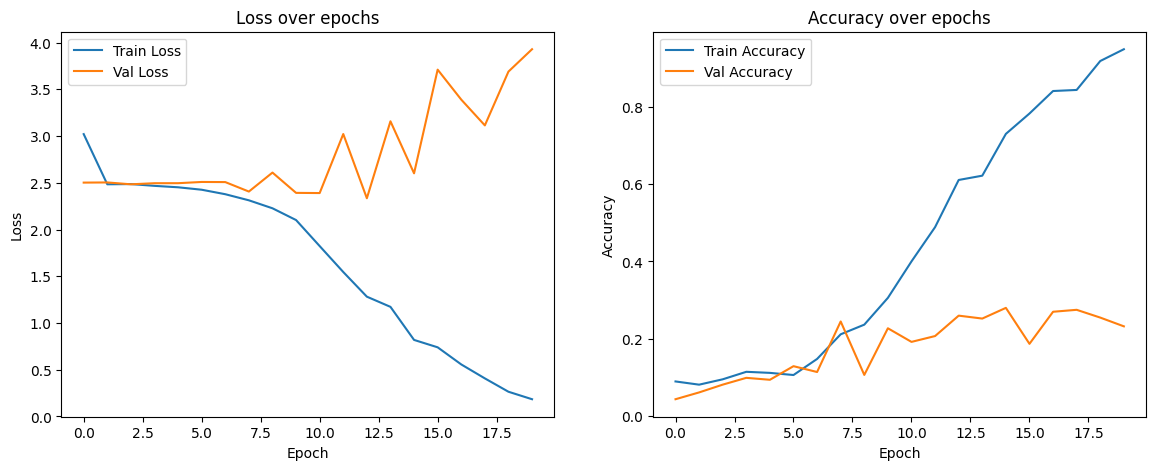

In [10]:


y_pred_prob = model_downsam.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Accuracy
test_acc_downsam = accuracy_score(y_true, y_pred)
print(f" Downsampled Test Accuracy: {test_acc_downsam:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot training history - Loss and Accuracy

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_downsam.history['loss'], label='Train Loss')
plt.plot(history_downsam.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_downsam.history['accuracy'], label='Train Accuracy')
plt.plot(history_downsam.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Model 4 : Class weights + Regularization : Dropout + BatchNorm + EarlyStopping

In [15]:
from tensorflow.keras import regularizers

y_train_classes = np.argmax(y_train_cat, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
class_weights_dict = dict(enumerate(class_weights))


def build_basic_cnn(input_shape=(128, 517, 1), num_classes=12):
    model = keras.Sequential([
        keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 517, 1), kernel_regularizer=regularizers.l2(1e-4)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Dropout(0.3),
    
        keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Dropout(0.3),
    
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(12, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



model_cw_reg = build_basic_cnn()
model_cw_reg.summary()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_cw_reg = model_cw_reg.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop],
    class_weight=class_weights_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 126, 515, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 515, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 257, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 63, 257, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 255, 32)         │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 255, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 127, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 127, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 121920)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       7,802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,808,716 (29.79 MB)

 Trainable params: 7,808,620 (29.79 MB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.0694 - loss: 12.8537 - val_accuracy: 0.0453 - val_loss: 69.8850
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.0784 - loss: 2.4501 - val_accuracy: 0.0453 - val_loss: 140.0122
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.0782 - loss: 2.5145 - val_accuracy: 0.0453 - val_loss: 197.6613
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.0837 - loss: 2.5175 - val_accuracy: 0.0453 - val_loss: 241.1613
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.0760 - loss: 2.4484 - val_accuracy: 0.0453 - val_loss: 268.0312
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0701 - loss: 2.4613 - val_accuracy: 0.0453 - val_loss: 277.6365


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
 Regularization Test Accuracy: 0.0453

Classification Report:
              precision    recall  f1-score   support

      amecro       0.00      0.00      0.00        13
      amerob       0.00      0.00      0.00        35
      bewwre       0.00      0.00      0.00        29
      bkcchi       0.00      0.00      0.00         9
      daejun       0.00      0.00      0.00        25
      houfin       0.00      0.00      0.00        17
      houspa       0.00      0.00      0.00       126
      norfli       0.00      0.00      0.00         7
      rewbla       0.00      0.00      0.00        38
      sonspa       0.00      0.00      0.00        53
      spotow       0.00      0.00      0.00        27
      whcspa       0.05      1.00      0.09        18

    accuracy                           0.05       397
   macro avg       0.00      0.08      0.01       397
weighted avg       0.00      0.05      0.00       397



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


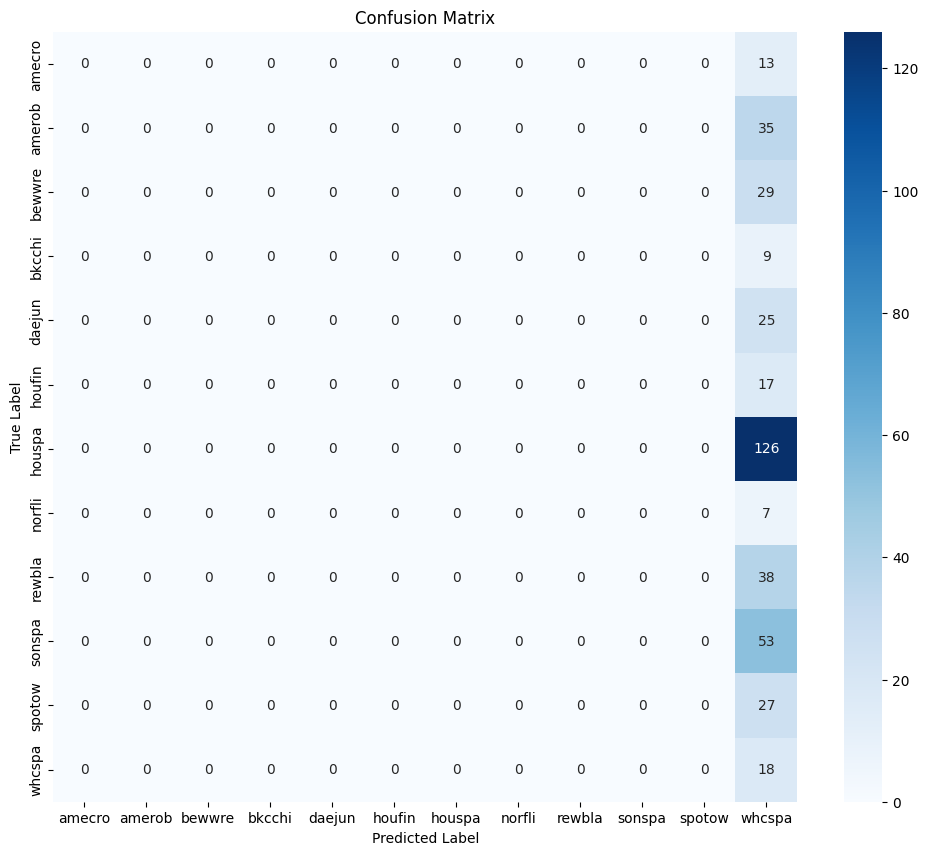

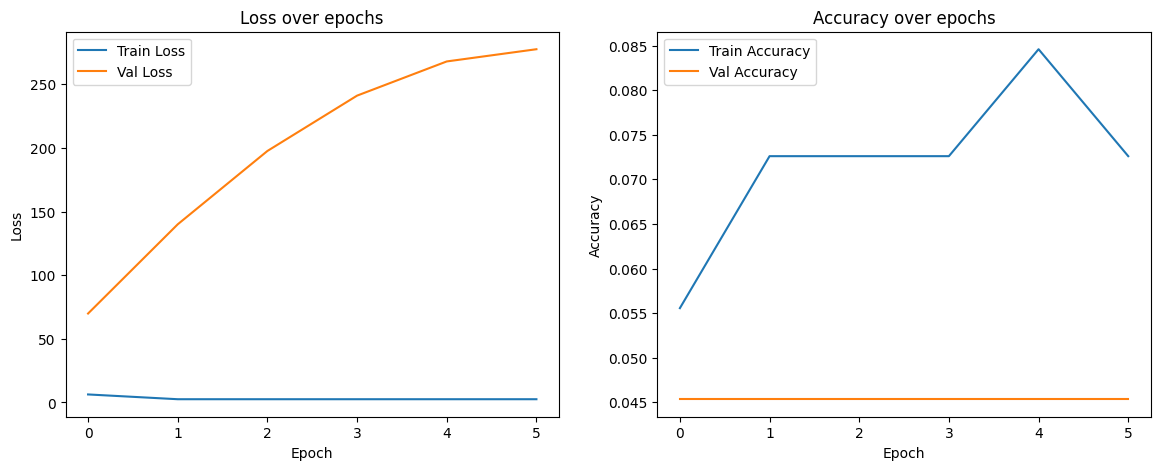

In [16]:
# Predict classes on test set
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

y_pred_prob = model_cw_reg.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Accuracy
test_acc_cwreg = accuracy_score(y_true, y_pred)
print(f" Regularization Test Accuracy: {test_acc_cwreg:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot training history - Loss and Accuracy

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_cw_reg.history['loss'], label='Train Loss')
plt.plot(history_cw_reg.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cw_reg.history['accuracy'], label='Train Accuracy')
plt.plot(history_cw_reg.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Model 5 :Class Weights + Focal Loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 128, 517, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 64, 258, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 258, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 32, 129, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 129, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 16, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 12)                  │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,871,564 (64.36 MB)

 Trainable params: 16,871,564 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.0914 - loss: 0.5673 - val_accuracy: 0.0856 - val_loss: 0.5212
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.1142 - loss: 0.5182 - val_accuracy: 0.2191 - val_loss: 0.5192
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.1548 - loss: 0.5167 - val_accuracy: 0.1914 - val_loss: 0.5055
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.1887 - loss: 0.4995 - val_accuracy: 0.2040 - val_loss: 0.4897
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.1961 - loss: 0.4892 - val_accuracy: 0.1965 - val_loss: 0.4774
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.2387 - loss: 0.4428 - val_accuracy: 0.2695 - val_loss: 0.4334
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3546 - loss: 0.3500 - val_accuracy: 0.3123 - val_loss: 0.3979
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.4625 - loss: 0.2542 - val_accuracy: 0.3426 -

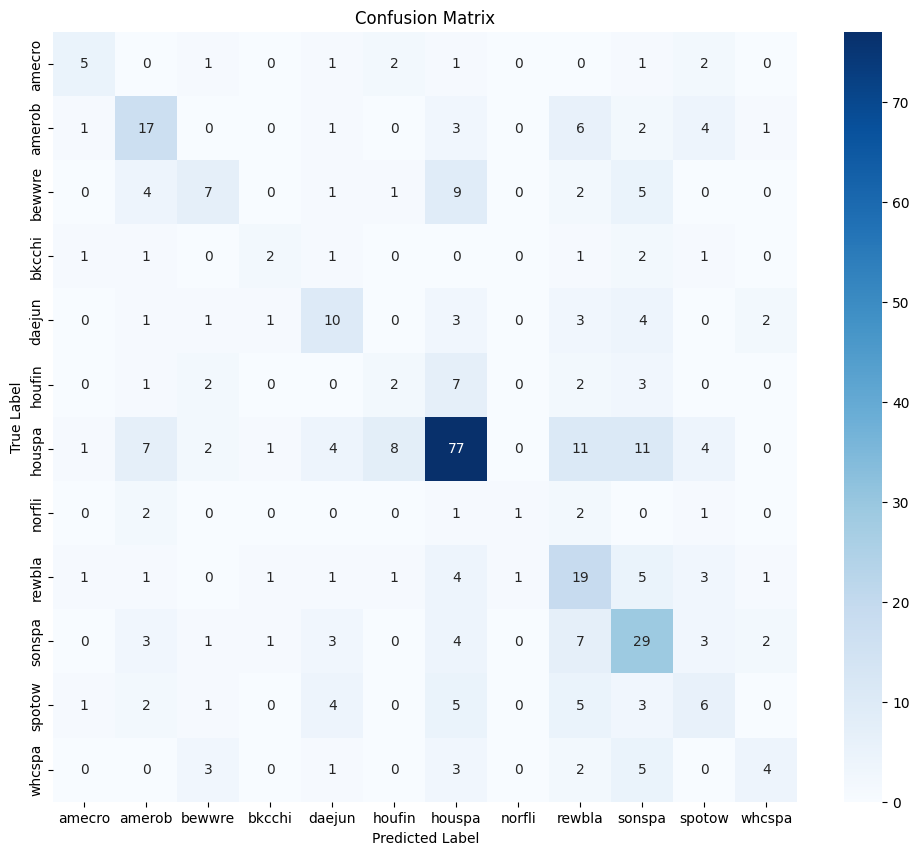

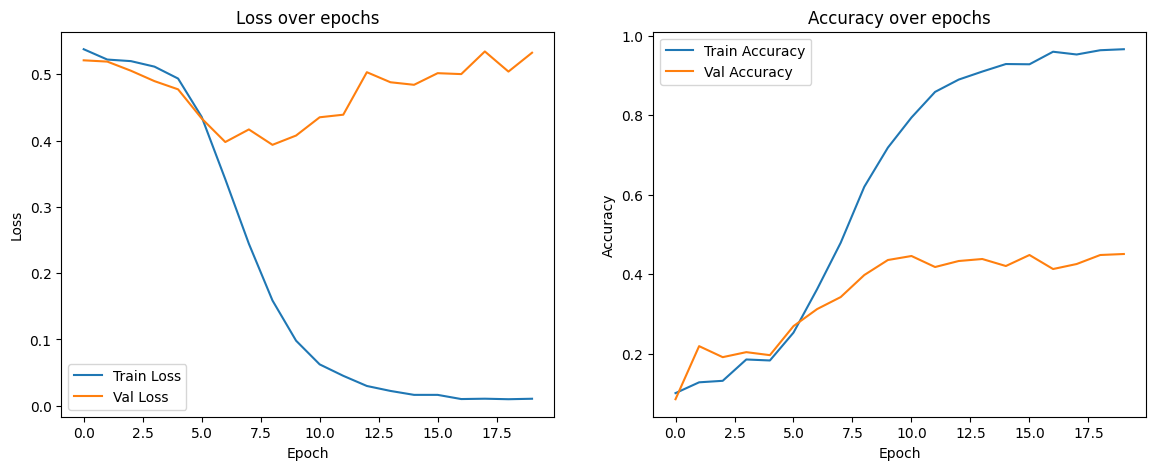

In [17]:
from tensorflow.keras import backend as K
y_train_classes = np.argmax(y_train_cat, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)
class_weights_dict = dict(enumerate(class_weights))


def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed


def build_basic_cnn(input_shape=(128, 517, 1), num_classes=12):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    
    model.compile(optimizer='adam',
                       loss=focal_loss(gamma=2.0, alpha=0.25),
                       metrics=['accuracy'])
    
    return model
    
model_cwfl = build_basic_cnn()
model_cwfl.summary()



history_cwfl = model_cwfl.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights_dict
)


# Predict classes on test set

y_pred_prob = model_cwfl.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Accuracy
test_acc_cwfl = accuracy_score(y_true, y_pred)
print(f" Class Weights Test Accuracy: {test_acc_cwfl:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot training history - Loss and Accuracy

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_cwfl.history['loss'], label='Train Loss')
plt.plot(history_cwfl.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cwfl.history['accuracy'], label='Train Accuracy')
plt.plot(history_cwfl.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step


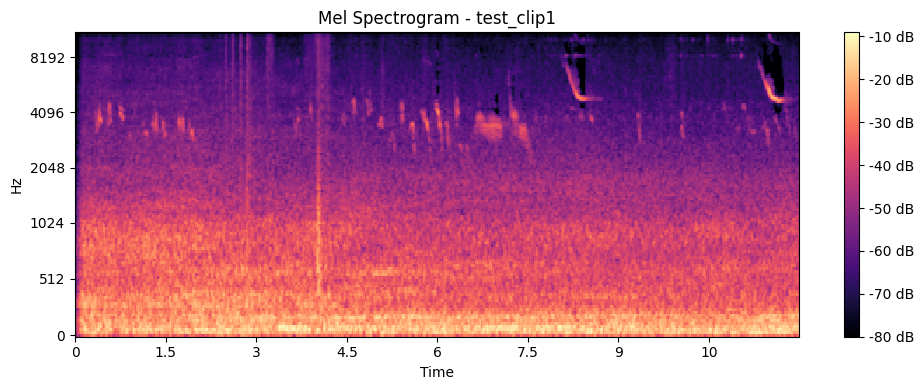

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


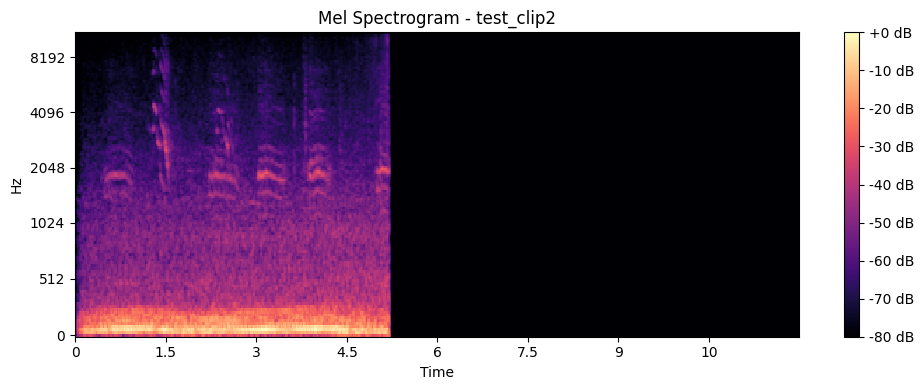

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


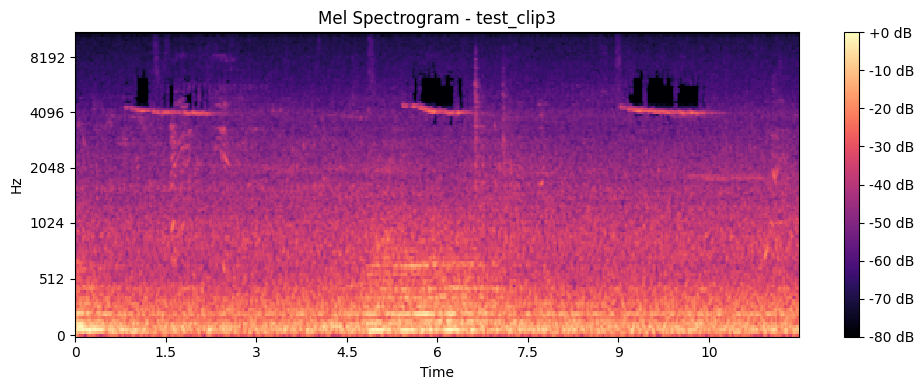


 Prediction Results:

test_clip1:
  Top 1: houspa (0.34)
  Top 2: rewbla (0.28)
  Top 3: houfin (0.18)

test_clip2:
  Top 1: houfin (0.37)
  Top 2: rewbla (0.19)
  Top 3: houspa (0.15)

test_clip3:
  Top 1: bkcchi (0.93)
  Top 2: whcspa (0.04)
  Top 3: rewbla (0.02)


In [18]:
# Imports
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

# The Best Model is the Class Weights + Focal Loss :
model =  model_cwfl
# Parameters
SAMPLE_RATE = 22050
N_MELS = 128
HOP_LENGTH = 512
SPEC_TIME_FRAMES = 517

# Function: Process MP3 to Mel Spectrogram
def process_audio_clip(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)

    # Generate Mel Spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
    S_db = librosa.power_to_db(S, ref=np.max)

    # Pad or Trim to Fixed Length
    if S_db.shape[1] < SPEC_TIME_FRAMES:
        pad_width = SPEC_TIME_FRAMES - S_db.shape[1]
        print(f"Warning: {os.path.basename(file_path)} was short. Padding {pad_width} frames.")
        S_db = np.pad(S_db, ((0, 0), (0, pad_width)), mode='constant', constant_values=S_db.min())
    else:
        S_db = S_db[:, :SPEC_TIME_FRAMES]

    # Normalize
    S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-8)
    S_norm = S_norm[..., np.newaxis]

    return S_norm, S_db

# Load test clips
test_clips = {
    'test_clip1': '/kaggle/input/nndata/test1.mp3',
    'test_clip2': '/kaggle/input/nndata/test2.mp3',
    'test_clip3': '/kaggle/input/nndata/test3.mp3'
}

predictions = {}
species_list = ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin',
                'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']

# Predict
for clip_name, file_path in test_clips.items():
    X_clip, S_db = process_audio_clip(file_path)
    X_clip = np.expand_dims(X_clip, axis=0)

    probs = model.predict(X_clip)[0]
    predicted_indices = np.argsort(probs)[::-1][:3]

    predictions[clip_name] = {
        'top_classes': predicted_indices,
        'top_probs': probs[predicted_indices]
    }

    # Plot Spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram - {clip_name}')
    plt.tight_layout()
    plt.show()

# Top-3 Predictions per Clip
print("\n Prediction Results:")
for clip, result in predictions.items():
    print(f"\n{clip}:")
    for idx, (cls_idx, prob) in enumerate(zip(result['top_classes'], result['top_probs'])):
        print(f"  Top {idx+1}: {species_list[cls_idx]} ({prob:.2f})")


Visualization of the Audio and Spectrogram Images 

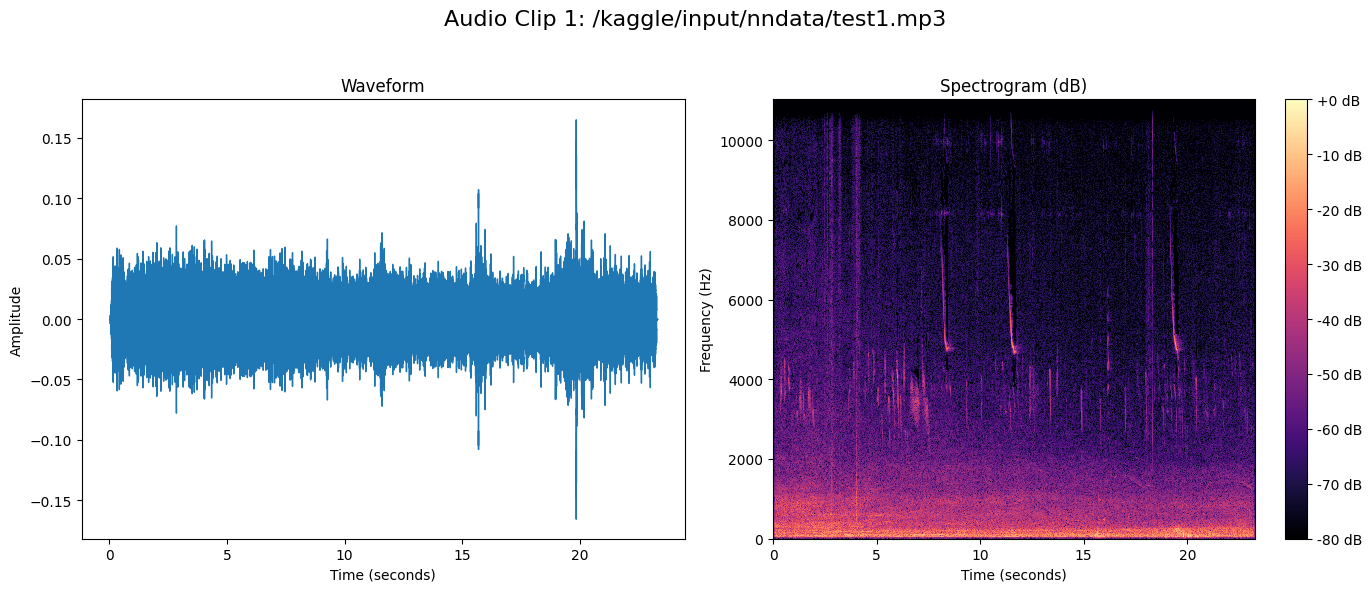

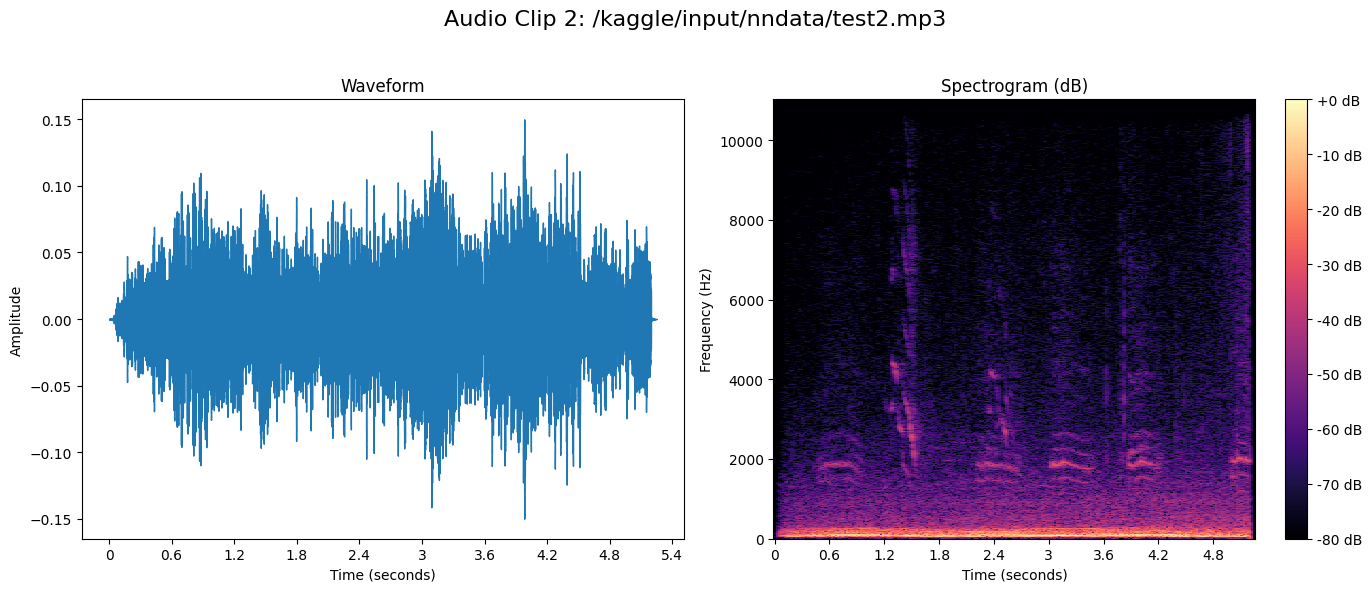

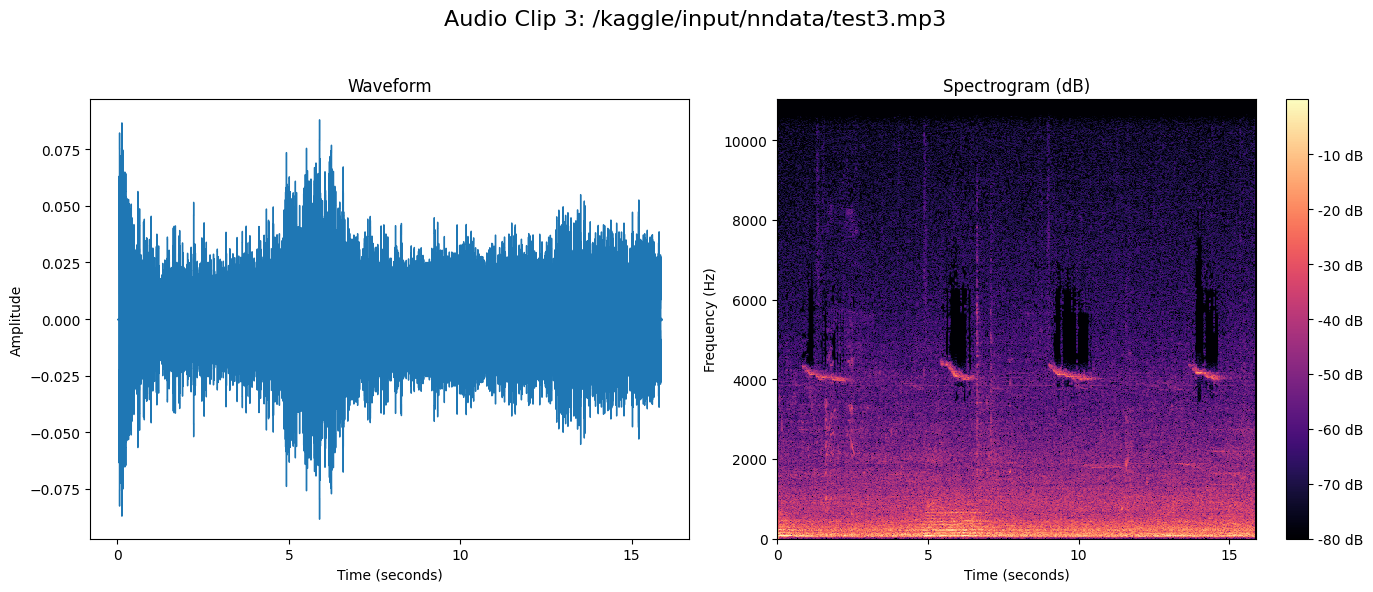

In [19]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def visualize_audio_clips(file_paths, sr=22050):
    
    for i, file_path in enumerate(file_paths):
        y, _ = librosa.load(file_path, sr=sr)

        plt.figure(figsize=(14, 6))
        plt.suptitle(f'Audio Clip {i+1}: {file_path}', fontsize=16)

        # Plot waveform
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title('Waveform')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')

        # Compute and plot spectrogram
        D = librosa.stft(y)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        plt.subplot(1, 2, 2)
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram (dB)')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency (Hz)')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


test_clip_paths = [
    '/kaggle/input/nndata/test1.mp3',
    '/kaggle/input/nndata/test2.mp3',
    '/kaggle/input/nndata/test3.mp3'
]

visualize_audio_clips(test_clip_paths)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


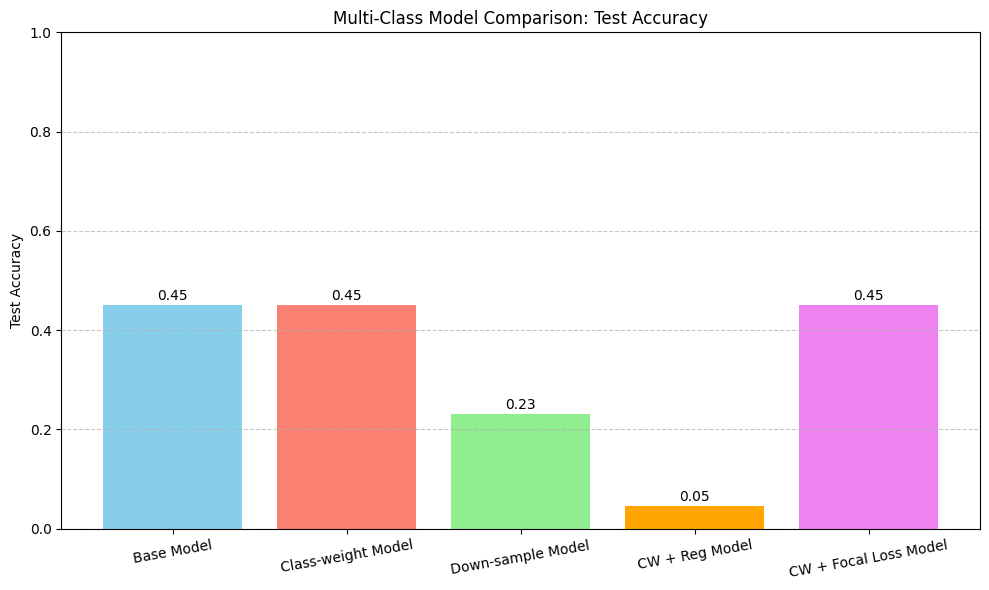

In [22]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Convert one-hot encoded y_test to class labels
y_test_labels = np.argmax(y_test_cat, axis=1)

# Predictions: use argmax to get predicted class labels
base_test_acc = accuracy_score(y_test_labels, np.argmax(model.predict(X_test), axis=1))
cw_test_acc = accuracy_score(y_test_labels, np.argmax(model_cw.predict(X_test), axis=1))
downsam_test_acc = accuracy_score(y_test_labels, np.argmax(model_downsam.predict(X_test), axis=1))
cwreg_test_acc = accuracy_score(y_test_labels, np.argmax(model_cw_reg.predict(X_test), axis=1))
cwfl_test_acc = accuracy_score(y_test_labels, np.argmax(model_cwfl.predict(X_test), axis=1))

# Model names and test accuracies
model_names = [
    'Base Model',
    'Class-weight Model',
    'Down-sample Model',
    'CW + Reg Model',
    'CW + Focal Loss Model'
]
test_accuracies = [
    base_test_acc,
    cw_test_acc,
    downsam_test_acc,
    cwreg_test_acc,
    cwfl_test_acc
]

# Bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, test_accuracies, color=['skyblue', 'salmon', 'lightgreen', 'orange', 'violet'])

# Add accuracy values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f'{height:.2f}', ha='center', fontsize=10)

plt.ylim(0, 1)
plt.ylabel('Test Accuracy')
plt.title('Multi-Class Model Comparison: Test Accuracy')
plt.xticks(rotation=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
